# Desagregación

Implementación del modelo mejor evaluado en la etapa de validación, correspondiente al modelo FHMM entrenado con datos promedio de potencia activa recopilados cada 30 segundos.

Librerías y otros ajustes:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

from nilmtk import TimeFrame, MeterGroup, HDFDataStore, DataSet
from nilmtk.utils import print_dict

labels = pd.DataFrame({'Instances': list(range(1,13)),
                       'Meters': ['M1','M2', 'Fridge', 'AACC', 'AACC', 'Washing machine','Computer','Clothes iron','unknown','Tv','Wet appliance','Motor']})
colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan','tab:grey']

## Set de Pruebas

In [2]:
test =DataSet('iawe.h5')
test.set_window(start="2013-08-24 05:30:00", end="2013-09-18 08:40:00")



test_elec = test.buildings[1].elec

#test_elec = test_elec.select(instance=[2,3,4,5,6])



test_Main=test_elec.mains() #medidor principal de cabecera
test_Main

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='iAWE', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='iAWE', site_meter, appliances=[])
)

In [3]:
test_elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='iAWE', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='iAWE', site_meter, appliances=[])
  ElecMeter(instance=3, building=1, dataset='iAWE', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=4, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=1)])
  ElecMeter(instance=5, building=1, dataset='iAWE', appliances=[Appliance(type='air conditioner', instance=2)])
  ElecMeter(instance=6, building=1, dataset='iAWE', appliances=[Appliance(type='washing machine', instance=1)])
  ElecMeter(instance=7, building=1, dataset='iAWE', appliances=[Appliance(type='computer', instance=1)])
  ElecMeter(instance=8, building=1, dataset='iAWE', appliances=[Appliance(type='clothes iron', instance=1)])
  ElecMeter(instance=9, building=1, dataset='iAWE', appliances=[Appliance(type='unknown', instance=1)])
  ElecMeter(instance=10, building=1, dataset='iAWE', appliances=[A

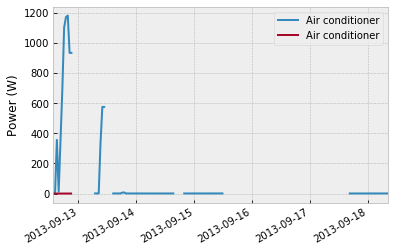

In [4]:
test_elec.plot()

Señal original vs señal desagregada

Usaremos como periodo de sampleo =300s

In [7]:
rcParams['figure.figsize'] = (10, 6)

ax1 = next(test_Main.load(ac_type='active', sample_period=1, resample_kwargs={'how':'first'})).plot(c='tab:red', lw=1.5) 
next(test_Main.load(ac_type='active', sample_period=300, resample_kwargs={'how':'median'})).plot(ax=ax1, c='k', lw=1.5) 

ax1.legend([('Main'),'period=30seg | method=median'], loc='upper left') #etiquetas
ax1.minorticks_off()   
ax1.set_ylabel('Power(W)')
ax1.set(xticks=('2013-08-24 05:30:00+01:00', '2013-09-18 08:40:00+01:00'))
ax1.set_xticklabels(labels=['11-10'], ha='left', rotation=0)    
plt.savefig('./data/images/6.1_Plot_test_30seg.svg', bbox_inches='tight', transparent=True)
pass

AttributeError: 'NaTType' object has no attribute 'normalize'

## Desagregación

In [10]:
from nilmtk.legacy.disaggregate import FHMM
from nilmtk import HDFDataStore

train = DataSet('iawe.h5')

train.set_window(start="2018-05-24 05:30:00", end="2018-07-24 05:24:00")
train_elec = train.buildings[1].elec

#Dispositivos para entrenamiento
train_Devices = train_elec.select(instance=[2,3,4,5,6])
train_Devices


#Set para validación
valid = DataSet('iawe.h5')
valid.set_window(start="2018-05-24 05:30:00", end="2018-05-24 05:30:00")
valid_elec = valid.buildings[1].elec

print('Medidor de cabecera para desagregación:')
valid_Main = valid_elec.mains()
print(valid_Main)

print('\nDispositivos para validación de entrenamiento:')
valid_Devices = valid_elec.select(instance=[3,4,5,6])
print(valid_Devices)


#Vamos a  volver a ejecutar esto
#FHMM_test.import_model('C:/data/FHMM_30seg_median_model.pickle') #modelo FHMM elegido


from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM


periods = { '10min':300}
methods = [ 'median']
times = {}

data_dir = './data/'
times = {} #almacena tiempos de ejecución
null={} #diccionario nulo


for sp_name, sp in periods.items():
    t = []
    for method in methods:
        models={'FHMM':FHMM()}
        for model_name, model in models.items():
            model.MIN_CHUNK_LENGTH = 1   
            print("*"*20 + ' ' + model_name + ' ' + sp_name+ ' ' + method + "*"*20)   
            import time
            start = time.time()
            model.train(train_Devices,
                num_states_dict={}, #diccionario de estados nulo, por defecto
                ac_type='active', #potencia activa, por defecto
                sample_period=30, #cambio de muestreo
                resample_kwargs={'how':'first'})#método 

            t.append(round(time.time()-start,2)) #tiempo de simulación

            #Guardamso el  modelo entrenado
            #Falla  al exprtarlo como model.pickle asi que lo salvamos en formato h5
            #model_dir = dir_models + model_name + '_1s_first_model.pickle'
            #print(model_dir)
            #model.export_model(model_dir) 
            output=HDFDataStore(data_dir+'NILM/Results/test_results.h5', 'w')
            
            model.disaggregate(valid_Main, output, sample_period=sp, resample_kwargs={'how':method}, ac_type='active')
            output.close()
            end = time.time()-start
            t.append(round(end,2))  

    times[sp_name] = t

  
            
    
print('\n\nDone!')



ValueError: end date must be after start date

Visualizar los datos de entrenamiento


In [ ]:
train_elec.plot()

Visualizar los datos de prueba

In [ ]:
test_elec.mains().plot()

### Resultados

In [ ]:
results=DataSet(data_dir+'NILM/Results/test_results.h5')
results_elec=results.buildings[1].elec # Todos los medidores
results_Main=results_elec.mains() #medidor de cabecera
results_Devices=results_elec.submeters() #predicciones

results_elec

### Metadatos

In [ ]:
print_dict(results.metadata)

In [ ]:
print_dict(results.buildings[1].metadata)

In [ ]:
print_dict(results_elec[1].get_metadata())

## Análisis Gráfico

### Todos los resultados

In [ ]:
d1=results_elec.fraction_per_meter()
ax1=d1.plot(autopct=lambda p:'{:.1f}%'.format(p), kind='pie',
            labels=labels[1:]+list(['Others']), figsize=(4.5,4.5),
            colors=colors)
ax1.set(ylabel="")
ax1.set(title='% de Energía Desagregada')
#guarda gráfico
plt.savefig('./data/images/6.2_Plot_results_1.1.svg', bbox_inches='tight', transparent=True)

In [ ]:
rcParams['figure.figsize'] = (8, 5)
fig, (ax1, ax2) = plt.subplots(1, 2)
test_elec.select(instance=[2,3,4,5,6]).fraction_per_meter().plot(ax=ax1, autopct=lambda p:'{:.1f}%'.format(p), kind='pie')
results_elec.select(instance=[2,3,4,5,6]).fraction_per_meter().plot(ax=ax2, autopct=lambda p:'{:.1f}%'.format(p), kind='pie')
ax1.set(ylabel="")
ax1.set(title='GT')
ax2.set(ylabel="")
ax2.set(title='Pred')

In [11]:
rcParams['figure.figsize'] = (6, 5)

df_d=test_elec.select(instance=[1]).dataframe_of_meters(ac_type='active')
ax1 = df_d.plot(kind='area',color=colors) 
next(test_elec[1].load(ac_type='active')).plot(ax=ax1, c='r')

#etiquetas
ax1.legend(labels[1:7])
ax1.set(title='Consumo Eléctrico Desagregado')
ax1.set_xticklabels(['1','2', '3', '4','5','6','7', '8','9'])
ax1.set(ylabel='Power (W)')
ax1.annotate("Periodo=1800s", xycoords='axes pixels', xy=(5, 110))
ax1.set_ylim(-100,3200)

TypeError: no numeric data to plot

In [12]:
rcParams['figure.figsize'] = (6, 5)

df_d=results_elec.select(instance=[1]).dataframe_of_meters(ac_type='active')
ax1 = df_d.plot(kind='area',color=colors) 
next(results_elec[1].load()).plot(ax=ax1, c='r')

#etiquetas
ax1.legend(labels[1:7])
ax1.set(title='Consumo Eléctrico Desagregado')
ax1.set_xticklabels(['1','2', '3', '4','5','6','7', '8','9'])
ax1.set(ylabel='Power (W)')
ax1.annotate("Periodo=1800s", xycoords='axes pixels', xy=(5, 110))
ax1.set_ylim(-100,2900)
#guarda gráfico
plt.savefig('./data/images/6.3_Plot_results_1.2.svg', bbox_inches='tight', transparent=True)
pass

NameError: name 'results_elec' is not defined

In [ ]:
#Energía de dispositivos
e_d=round(results_elec.energy_per_meter().transpose()['active'][1:],1)
print('\n\nEnergía de Dispositivos:')
print(e_d)

#Energía total de dispositivos
e_t=round(sum(e_d),2)
print('\nEnergía Total Dispositivos: '+str(e_t))

#energía medida por Mains_RST
e_m=round(results_elec.mains().total_energy(),1)
print('\nEnergía Main Principal: '+str(e_m[0]))

#energía no medida
print('\nEnergía No medida: '+str(e_m[0]-e_t))

In [ ]:
rcParams['figure.figsize'] = (6, 5)

df_d=results_elec.select(instance=[2,3,4,5,6]).dataframe_of_meters(ac_type='active')

ax1 = df_d.plot(kind='area',color=colors)   
#etiquetas
ax1.legend(labels[1:7])
ax1.set(title='Consumo Eléctrico Desagregado')
ax1.set_xticklabels(['2-Feb','10:00', '10:30', '11:00','11:30','12:00','12:30', '13:00','13:15'])
ax1.set(ylabel='Power (W)')
#ax1.annotate("Periodo=30s", xycoords='axes pixels', xy=(5, 110))
ax1.set_ylim(-100,2000)
#guarda gráfico
plt.savefig('./data/images/6.3_Plot_results_1.2.svg', bbox_inches='tight', transparent=True)

## Desagregacion otra manera

In [ ]:
from __future__ import print_function, division
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from six import iteritems

from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM
import nilmtk.utils

%matplotlib inline


top_5_train_elec = train_elec.submeters().select_top_k(k=5)
top_5_train_elec

In [ ]:
def predict(clf, test_elec, sample_period, timezone):
    pred = {}
    gt= {}
    
    # "ac_type" varía según el conjunto de datos utilizado. 
    # Asegúrese de usar la ac_type correcta antes de usar los parámetros predeterminados en este código.    
    for i, chunk in enumerate(test_elec.mains().load(physical_quantity = 'power', ac_type = 'apparent', sample_period=sample_period)):
        chunk_drop_na = chunk.dropna()
        pred[i] = clf.disaggregate_chunk(chunk_drop_na)
        gt[i]={}

        for meter in test_elec.submeters().meters:
            # Solo use los medidores en los que entrenamos (¡esto ahorra tiempo!)  
            gt[i][meter] = next(meter.load(physical_quantity = 'power', ac_type = 'active', sample_period=sample_period))
        gt[i] = pd.DataFrame({k:v.squeeze() for k,v in iteritems(gt[i]) if len(v)}, index=next(iter(gt[i].values())).index).dropna()
        
    # Si todo cabe en la memoria
    gt_overall = pd.concat(gt)
    gt_overall.index = gt_overall.index.droplevel()
    pred_overall = pd.concat(pred)
    pred_overall.index = pred_overall.index.droplevel()

    # Tener el mismo orden de columnas
    gt_overall = gt_overall[pred_overall.columns]
    
    #Interseccion del índice
    gt_index_utc = gt_overall.index.tz_convert("UTC")
    pred_index_utc = pred_overall.index.tz_convert("UTC")
    common_index_utc = gt_index_utc.intersection(pred_index_utc)
    
    common_index_local = common_index_utc.tz_convert(timezone)
    gt_overall = gt_overall.loc[common_index_local]
    pred_overall = pred_overall.loc[common_index_local]
    appliance_labels = [m for m in gt_overall.columns.values]
    gt_overall.columns = appliance_labels
    pred_overall.columns = appliance_labels
    return gt_overall, pred_overall

In [ ]:
classifiers = {'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}
predictions = {}
sample_period = 30
for clf_name, clf in classifiers.items():
    print("*"*20)
    print(clf_name)
    print("*" *20)
    start = time.time()
    # Tenga en cuenta que hemos dado el período de muestra para reducir la resolución de los datos a 1 minuto.
    # Si en lugar de top_5 quisiéramos entrenar en todos los dispositivos, escribiríamos
    # fhmm.train (train_elec, sample_period = 60)
    clf.train(top_5_train_elec, sample_period=sample_period)
    end = time.time()
    print("Runtime =", end-start, "seconds.")
    gt, predictions[clf_name] = predict(clf, test_elec, sample_period, train.metadata['timezone'])

In [ ]:
rmse = {}
for clf_name in classifiers.keys():
    rmse[clf_name] = nilmtk.utils.compute_rmse(gt, predictions[clf_name], pretty=True)

rmse = pd.DataFrame(rmse)